
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import re

from unidecode import unidecode

import matplotlib.pyplot as plt

#### Tarefa: Classificação de ratings das avaliações de clientes:
- 4 e 5: Positiva
- 1 e 2: Negativa
- 3: Descartadas


#### Importação do dataset

In [2]:
df = pd.read_csv('../datasets/b2w.csv')

#### Removendo colunas que não serão utilizadas

In [3]:
columns_to_remove = ['original_index', 'review_text_processed', 'review_text_tokenized', 'polarity', 'kfold_polarity', 'kfold_rating']

In [4]:
df = df.drop(columns=columns_to_remove, axis=1)

In [5]:
df.head(3)

,review_text,rating
0,Bem macio e felpudo...recomendo. Preço imbatí...,4
1,Produto excepcional! recomendo!!! inovador e ...,5
2,recebi o produto antes do prazo mas veio com d...,1


In [7]:
print(f'Dataset original: {df.shape[0]} instancias, {df.shape[1]} classes')

Dataset original: 132373 instancias, 2 classes


#### Pré-processamento

#### Verificando registros nulos

In [8]:
df.isnull().any()

review_text    False
rating         False
dtype: bool

In [9]:
df['review_text'].isnull().sum()

0

In [10]:
df[df['review_text'].isnull()]

,review_text,rating


#### Removendo registros nulos

In [11]:
df = df.dropna()

In [12]:
df.isnull().any()

review_text    False
rating         False
dtype: bool

In [13]:
df.shape

(132373, 2)

#### Padronizando texto em lowercase

In [14]:
def to_lowercase(text):
    text = text.apply(lambda x: " ".join(x.lower().split()) if isinstance(x, str) else "")
    return text

In [15]:
df["review_text"] = to_lowercase(df["review_text"])

#### Removendo caracteres especiais e substituindo cedilhas por c

In [16]:
def preprocess_text(text):
    # removendo caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    # unidecode translitera caracteres acentuados e especiais para formas sem acento ou caracteres equivalentes
    text = unidecode(text)
    return text

In [17]:
df['review_text'] = [preprocess_text(doc) for doc in df['review_text']]

#### Removendo hiperlinks

In [18]:
def remove_hiperlink(text):
    text = re.sub(r"(https?://[^\s]+|www\.[^\s]+)", '', text)
    return text

In [19]:
df['review_text'] = [remove_hiperlink(doc) for doc in df['review_text']]

#### Descartando instâncias com avaliação igual a 3

In [20]:
rating_3 = df['rating'] == 3
rating_3.sum()

16315

In [21]:
df = df[df['rating'] != 3]

In [22]:
df.shape

(116058, 2)

#### Ajustando ratings:
- 1 e 2 = 0
- 4 e 5 = 1

In [23]:
# Caso necessite binarização
df['rating'] = list(map(lambda x: 0 if x<=2 else 1, df['rating']))

In [26]:
df_rating_counts = df['rating'].value_counts()
df_rating_counts

rating
1    80300
0    35758
Name: count, dtype: int64

In [25]:
print(f'{df_rating_counts[1]} Avaliações Positivas')
print(f'{df_rating_counts[0]} Avaliações Negativas')

80300 Avaliações Positivas
35758 Avaliações Negativas


#### Nota-se que o dataset está desbalanceado

In [27]:
def plot_barchart(data):
    rating_counts = data
    labels = [f'{data[1]} Avaliações Positivas', f'{data[0]} Avaliações Negativas']

    # Criar o gráfico de barras
    plt.bar(labels, rating_counts)

    # Adicionar rótulos e título
    plt.xlabel('Ratings')
    plt.ylabel('Contagem')
    plt.title('Gráfico de Barras de Ratings')

    # Mostrar o gráfico
    plt.show()

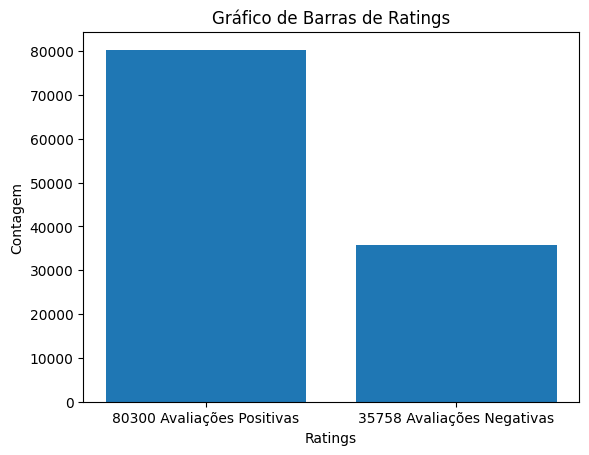

In [28]:
plot_barchart(df_rating_counts)

#### Utilizamos a técnica de reamostragem RandomUnderSampler para resolver o problema de desbalanceamento das classes
- Desta forma, ela tenta igualar número de amostras da classe majoritária com a classe minoritária;

In [29]:
from imblearn.under_sampling import RandomUnderSampler

In [30]:
# Gerando uma cópia do dataset
df_balanced = df.copy()

In [31]:
rus = RandomUnderSampler()

#### Separarando os recursos (X) e os rótulos (y)

In [32]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df_balanced['review_text'])
X = X.reshape(-1, 1)

In [33]:
y = df_balanced['rating']

In [34]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = rus.fit_resample(X, y)

In [35]:
print(pd.Series(y_res).value_counts())

rating
0    35758
1    35758
Name: count, dtype: int64


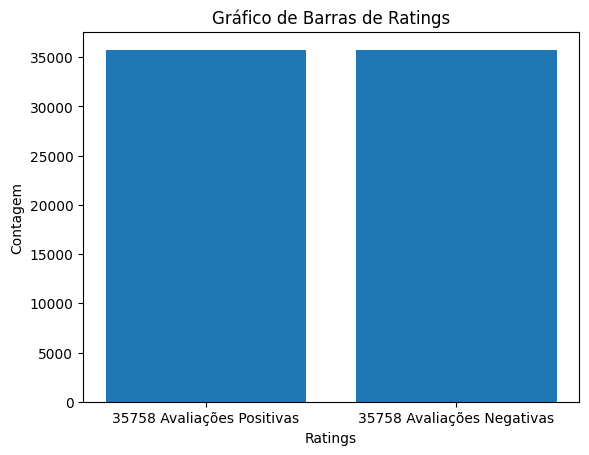

In [36]:
plot_barchart(y_res.value_counts())

In [37]:
def clear_sentences(sentences):
    new_list_texts = []
    for item in sentences:
        item = str(item)
        item_fixed = item[1:-1]  
        new_list_texts.append(item_fixed)
    
    return [s[1:-1] for s in new_list_texts]

In [38]:
texts = clear_sentences(X_res)
labels = y_res

In [39]:
df_balanced = {
    'review_text' : texts,
    'rating' : labels
}

In [40]:
preprocessed_balanced_df = pd.DataFrame(df_balanced)

In [41]:
preprocessed_balanced_df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [43]:
print(f'Após o pré-processamento e balanceamento da base b2w: {preprocessed_balanced_df.shape[0]} instâncias, {preprocessed_balanced_df.shape[1]} classes')

Após o pré-processamento e balanceamento da base b2w: 71516 instâncias, 2 classes


In [44]:
preprocessed_balanced_df.to_csv('../datasets/b2w_preprocessed.csv', index=False)